<a href="https://colab.research.google.com/github/georgeaidinis/Dissertation/blob/main/BE_5370_HW_1_20_tiny_grass_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BE 5370 Homework Assignment 1 team 20_tiny_grass

George Aidinis      (Penn ID: 83836648)

Dimitris Pantelaios (Penn ID: 60385374)

## Configuration Section

### Assignment Directory + "Local" parameter

In [ ]:
# local = True
local = False
# dimitris = True

if dimitris:
  data_prefix = 'D:/HW1 Biomedical - Data/'
else:
  data_prefix = ''

if local:
  data_path = data_prefix + 'hemi_training/'
  segmentation_path = data_prefix + '2.3/'
  output_path = data_prefix + '2.5/'
  N4_corrected_hemispheres_path = data_prefix + '3.1/'
else:
  data_path = '/content/drive/MyDrive/BIA_Segmentation/BIA_Segmentation_Dataset/'
  segmentation_path = '/content/drive/MyDrive/BIA_Segmentation/2.3/'
  output_path = '/content/drive/MyDrive/BIA_Segmentation/2.5/'

### Connect the Colab instance to the Google Drive

In [ ]:
import os

if not local:
  from google.colab import drive

  if not os.path.ismount("/content/drive"):
    drive.mount('/content/drive')

  if not local:
    !cd /content/drive/MyDrive/BIA_Segmentation

### Install instructor-provided utilities for this assignment

In [ ]:
!pip install --upgrade git+https://github.com/pyushkevich/upenn_be5370_utils.git --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 12.5 MB/s eta 0:00:00


### Import all the necessary stuff

In [ ]:
import os

import numpy as np
import SimpleITK as sitk
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from upenn_be5370_utils.sitkview import view_sitk
from upenn_be5370_utils.sitkview import view_hemi


### Install nnU-Net and create the directory structure

In [ ]:
# Set an environment variable for the path where we clone the nnUNet repository:
os.environ['NNUNET_REPO']=os.path.join(BIA_Segmentation, 'nnUNet')

# This system command clones the repository if it does not exist:
!if [[ ! -d $NNUNET_REPO ]]; then git clone https://github.com/MIC-DKFZ/nnUNet.git $NNUNET_REPO; fi

# This command installs nnUNet on the runtime:
!cd $NNUNET_REPO && pip install -e . --quiet

# This command installs an optional package used by nnUNet:
!pip install --upgrade git+https://github.com/FabianIsensee/hiddenlayer.git --quiet

# Create the nnUNet directory structure:
for d in ['nnUNet_raw','nnUNet_preprocessed','nnUNet_results']:
  d_fullpath = os.path.join(BIA_Segmentation, d)
  os.makedirs(d_fullpath, exist_ok=True)
  os.environ[d] = d_fullpath
  print(f'Setting {d}={d_fullpath}')

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 6.5 MB/

## Main Section


### 2 Phase I: Image Processing

#### 2.1 Step I-A. Examine hemisphere scans in ITK-SNAP:

We have 40 total scans (20 T2 and 20 CISS scans) from 20 subjects, which we loaded and examined through ITK-SNAP.

Viewing the T2 scans, it's immediately clear that they suffer from dropout artifacts, meaning that there is an intensity drop at the front and the back of the head due to scanning method. We experimented with both viewing the images alternating, side by side, as well as an overlay, toggling with the opacity of the overlay to see any differences.

Using the `Image Layer Inspector` tool of ITK-SNAP, we tinkered with both the contrast of the T2 images, as well as the colormap. In most cases, the dropout artifact effect is diminished, however not completely; in some cases, changing the contrast and the colormap helps but to a point, as the effect is too severe.

In our experiments, we found that the `jet` and `hot` colormap configurations worked best to highlight the front and rear parts of the brain, however even so we needed to use the `Color Map Editor` (from the `Color Map` tab of the Inspector tool) to play around with the relative intensities of the gradients.

Regarding the contrast, it's clear that no matter the granularity of the contrast curve, there will always be some remnant of the dropout artifact. We explored the automatic contrast tool, but preferred the manual curve setting, where we added nodes so as to increase the contrast of the lower intensity values, while managing the rest of the curve. While the intensity histogram bins were helpful if they were more granular, it didn't provide the solution we were looking for.

Below are some screenshots from our experimentations.

![](https://drive.google.com/uc?export=view&id=19cWe5JukJ5YiqVMGfJn3H2eThZG7L2vT)

---

![](https://drive.google.com/uc?export=view&id=1BNmCthrsCmVEAj0Pk4s_eAHg-uC-F_pm)

---

![](https://drive.google.com/uc?export=view&id=1aeRMlMN1NR8M3wtF3lg3OLUvPwzqRjBQ)

---

![](https://drive.google.com/uc?export=view&id=1tbi8frWrTr5Pa2eigFJ1ASXa3dKQdhwo)

---

![](https://drive.google.com/uc?export=view&id=1WHsWYMheGK1k2KBpw73qT8XxqtT18ON1)

---

![](https://drive.google.com/uc?export=view&id=1IHi4m93rHWwaKaIxxgIEHDJQsRu3cVim)

---

![](https://drive.google.com/uc?export=view&id=1e6I5OmdjN2Vb9cFqBGbU5wSnIZg7YSdD)

---

![](https://drive.google.com/uc?export=view&id=19_1A_iR-MmQuqOfgW2PsB1CPR4w8hUXT)

---

![](https://drive.google.com/uc?export=view&id=1IOgBPwC2aXykZ5yh1AbSJTFMUAcW9zCu)

---

![](https://drive.google.com/uc?export=view&id=1xd2VdYmbvemdQvLW-qSkVnhnOrh8JsBl)

#### 2.2 Step I-B. Read the N4 paper and identify parameters to tune:

There are several parameters that affect the performance of the N4 algorithm, including spline distance, full width at half maximum, shrink factor, convergence threshold, maximum number of iterations, image mask, and number of multiresolution levels. Among these, we will focus on three key parameters for our experiments:

**Spline Distance:**

* This parameter defines the distance between the knots of the B-spline mesh used to approximate the bias field. Generally, smaller Spline Distance captures finer variations in the bias field but may overfit noise, while larger Spline Distance may result in a smoother bias field correctiom.

* Range: Commonly used spline distances range from 50 to 100 mm, while smaller distances, such as 30–50 mm, may capture finer variations in the bias field, potentially yielding more accurate results.

**Multiresolution Levels:**

*   This parameter controls the hierarchical fitting of the bias field, progressively refining the fit at higher levels of frequency modulation.
*   Range: We will experiment with 1 to 4 resolution levels to assess how different levels of refinement affect the accuracy of bias field correction.

**Maximum Number of Iterations:**

*  This defines the upper limit on the number of iterations the algorithm will perform at each resolution level before stopping, either upon convergence or after reaching the set limit.
*   Range: We plan to use 50 to 200 iterations, as these values are commonly applied in bias field correction to balance accuracy and computational cost.



#### 2.3 Step I-C. Generate an dataset for evaluating N4:

The segmentations from the subjects can be found in our [Google Drive](https://drive.google.com/drive/u/2/folders/1ooWMJTL3cZDqTOEoyGIVnI9ZaFx2k5wN) (access inside Penn is permitted).

Below we present some examples of the partial segmentation and labeling conducted on the 17th subject:

![](https://drive.google.com/uc?export=view&id=1K2vfmeDrNJMRPPZyDhU0tk-FoTMBufXf)

---

![](https://drive.google.com/uc?export=view&id=1hn-CptXAinqaaCWkRSKBjky332emN8ws)

#### 2.4 Step I-D. Write Python code to run the N4 algorithm:

First, let's view the T2 alone, as well as the CISS image overlayed on top of the T2 image:

In [ ]:
import SimpleITK as sitk
from upenn_be5370_utils.sitkview import view_sitk
from upenn_be5370_utils.sitkview import view_hemi

# Load a T2 scan and a CISS scan and display them:
image_t2 = sitk.ReadImage(data_path + 'subj_002_t2.nii.gz')
image_ciss = sitk.ReadImage(data_path + 'subj_002_ciss.nii.gz')

view_hemi(image_t2, cmap='gray', name='T2-weighted MRI') # View T2 scan
view_hemi([image_t2, image_ciss], cmap=['gray','hot'], alpha=0.5, name=['T2', 'CISS']) # View T2 scan overlaid by CISS scan

Below we experiment with different masks. As per the suggestion from the homework instructions, we try first the OTSU mask, which indeed gives a good mask.

We also try a binary threshold mask, after we apply smoothing. This seems to not be working so well, however with more experimentation we may be able to get it to produce good enough results.

Finally, we also try to experiment with K-Means clustering masking, using 2 clusters, essentially separating the brain from the background. This also works well.

/Users/georgeaidinis/miniconda3/envs/BIA/lib/python3.10/site-packages/upenn_be5370_utils/sitkview.py:223: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


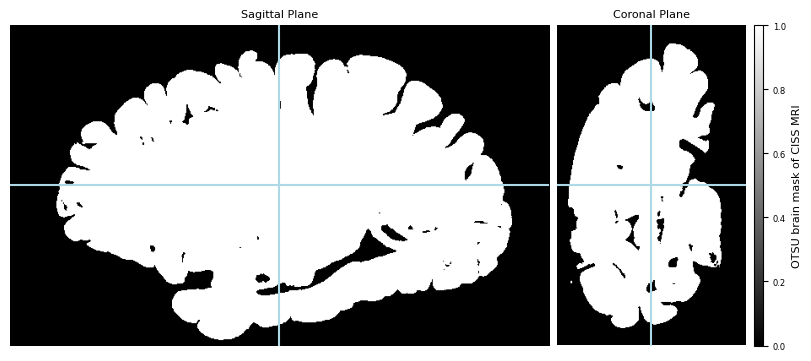

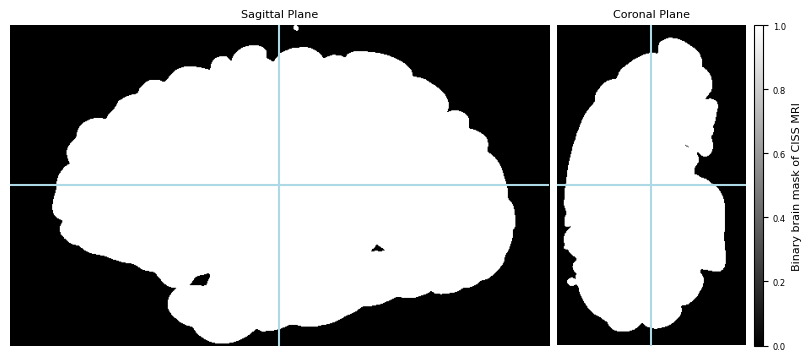

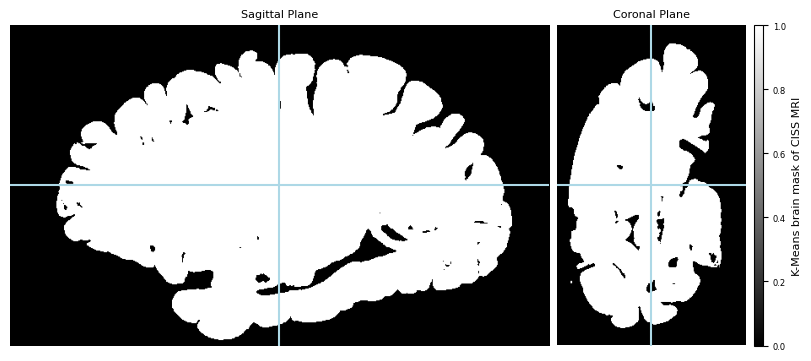

In [ ]:
# Generate brain masks:
# 1) OTSU:
brain_mask_OTSU = sitk.OtsuThreshold(image_ciss, 0, 1, 200) # Inside value is 1, outside is 0. Num of bins=200

# 2) Binary after gaussian smoothing
smoothed_image = sitk.SmoothingRecursiveGaussian(image_ciss, sigma=0.6) # 0.6 removes background grains, higher is too smoothed.
lower_threshold = 100
upper_threshold = 2000
brain_mask_binary = sitk.BinaryThreshold(smoothed_image, lowerThreshold=lower_threshold, upperThreshold=upper_threshold)

# 3) K-means clustering
import numpy as np
from sklearn.cluster import KMeans

image_array = sitk.GetArrayFromImage(image_ciss).flatten().reshape(-1, 1)
kmeans = KMeans(n_clusters=2).fit(image_array)
labels = kmeans.labels_.reshape(sitk.GetArrayFromImage(image_ciss).shape)
brain_mask_kmeans = sitk.GetImageFromArray((labels == 1).astype(np.uint8))


# View brain masks:
view_hemi(brain_mask_OTSU, cmap=['gray'], name=['OTSU brain mask of CISS MRI'])
view_hemi(brain_mask_binary, cmap=['gray'], name=['Binary brain mask of CISS MRI'])
view_hemi(brain_mask_kmeans, cmap=['gray'], name=['K-Means brain mask of CISS MRI'])

Before we apply the N4 algorithm, we must first downsample the image, as well as the mask. Downsampling the image creates aliasing effects, so therefore we smooth before downsampling.

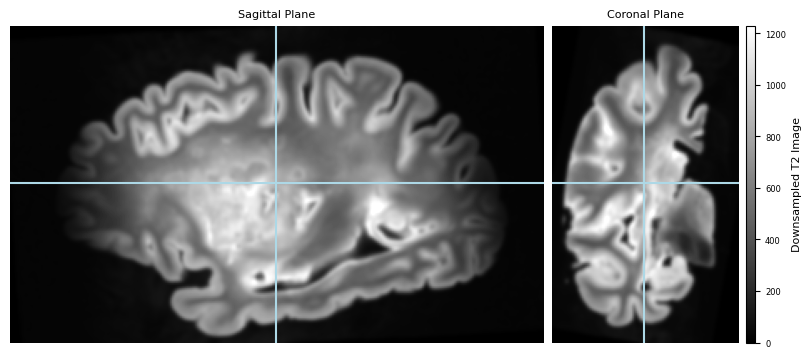

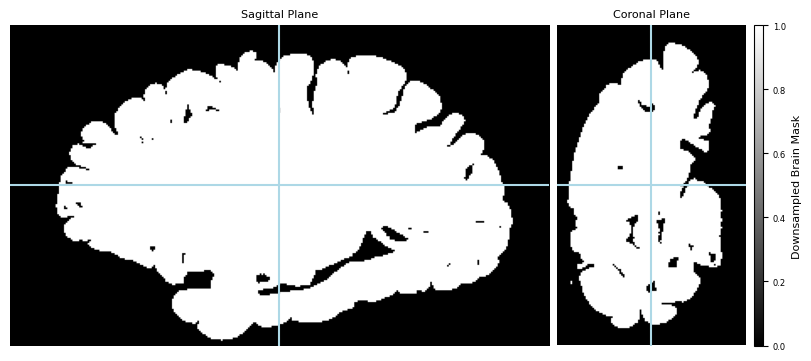

In [ ]:
# Define shrink factors and sigma:
shrink_factors = [2] * image_t2.GetDimension()
sigma = 0.65  # 0.65 seems like it works OK.

# Apply low-pass filter and downsample the T2 image:
img_after_low_pass = sitk.SmoothingRecursiveGaussian(image_t2, sigma)
downsampled_img = sitk.Shrink(img_after_low_pass, shrink_factors)
view_hemi(downsampled_img, cmap='gray', name="Downsampled T2 Image")

# Downsample the brain mask
downsampled_brain_mask = sitk.BinShrink(brain_mask_OTSU, shrink_factors) # Here we select the OTSU brain mask.
view_hemi(downsampled_brain_mask, cmap='gray', name="Downsampled Brain Mask")

Now, we run the N4 algorithm. This is the sample initialization for the parameters, before our experimentation. We choose 3 resolution levels, a small convergence threshold so that all iterations run, and the Bias Field Full Widht at Half Maximum (FWHM) at the default value, 0.15. We didn't experiment here with spline distances, however that is done later in the code.

We notice that while the N4 algorithm has a noticeable effect on the original image, however it's not as big an improvement as one might expect. We aim on improving this however further below. We present the images of the log bias field, as well as a comparison between the input image and the N4-corrected T2 image.

***Note:*** Due to an error we encountered, it seems that we need to cast one of the two images (either the input image or the corrected image) to the other's type, because they're incompatible for the division (`uint16 != float32`)

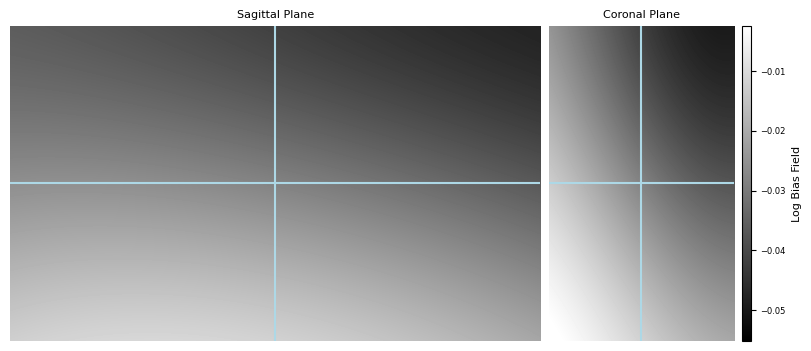

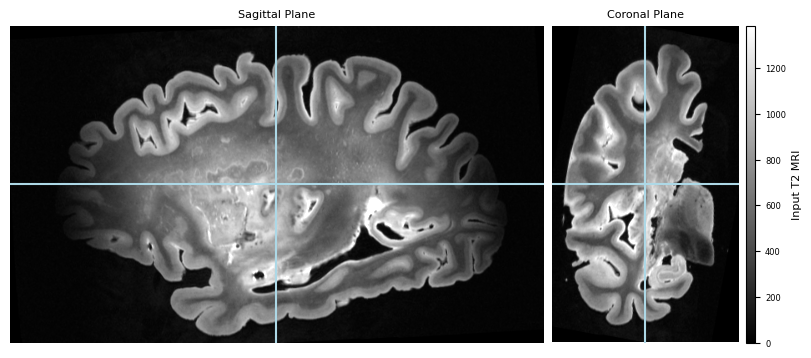

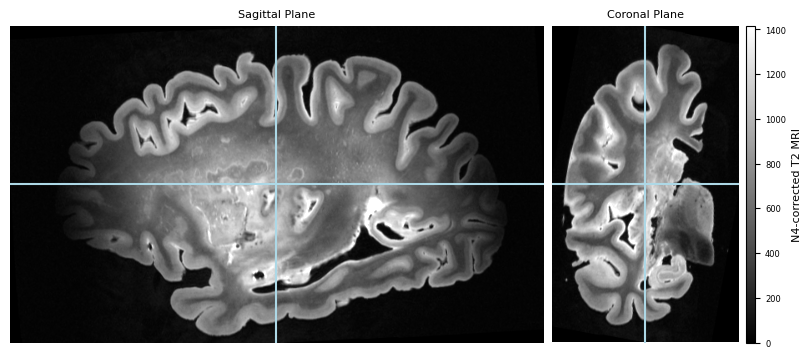

In [ ]:
# Initialize N4 filter and set parameters:
# 50 iterations at the lowest (coarsest) resolution level (default)
# If we had more layers, then the first is the coarsest, and the last is the highest (full) resolution layer
# Convergence threshold to 10^-6 (very small to force iterations)
# Bias Full Width at Half Maximum: 0.15 (paper suggested, default)
N4 = sitk.N4BiasFieldCorrectionImageFilter()
N4.SetMaximumNumberOfIterations([50])
N4.SetConvergenceThreshold(1e-6)
N4.SetBiasFieldFullWidthAtHalfMaximum(0.15)

# Run N4 bias field correction
corrected_downsampled_img = N4.Execute(downsampled_img, downsampled_brain_mask)

# Get the log bias field and apply it to the full-resolution image
log_bias_field = N4.GetLogBiasFieldAsImage(image_t2)

# Due to a division error, we have to cast the original input image to Float32, because the Divide function requires both input images to have the same pixel type.
image_t2_float = sitk.Cast(image_t2, sitk.sitkFloat32)
corrected_image_full_res = sitk.Divide(image_t2_float, sitk.Exp(log_bias_field))
view_hemi(log_bias_field, cmap='gray', name='Log Bias Field')
view_hemi(image_t2, cmap='gray', name='Input T2 MRI')
view_hemi(corrected_image_full_res, cmap='gray', name='N4-corrected T2 MRI')

#### 2.5 Step I-E. Parameter Evaluation:

First, let's define:
- the function for computing the Cohen's d statistic,
- the function for computing the mean and standard deviations,
- the function for computing the brain mask,
- the function for downsampling given a shrink size,
- the subject list we're going to use for training, as well as all subject names,
- the label values for the different tissue types:

In [ ]:
# Function to compute Cohen's d statistic.
def compute_cohens_d(mean1, std1, mean2, std2):
    pooled_std = np.sqrt((std1**2 + std2**2) / 2)
    d = np.abs(mean1 - mean2) / pooled_std
    return round(d, 4) # Rounding to 4 digits should be enough

# Function to compute statistics for a given label, calculating over the areas that are segmented.
def compute_statistics(image_array, label_array, label_value):
    voxels = image_array[label_array == label_value]
    mean_intensity = np.mean(voxels)
    std_intensity = np.std(voxels)
    return round(mean_intensity, 4), round(std_intensity, 4) # Rounding to 4 digits should be enough

# Function to compute the brain mask of the image.
def compute_brain_mask(image_ciss, brain_mask_type='OTSU'):
    # OTSU:
    if brain_mask_type == 'OTSU':
        brain_mask = sitk.OtsuThreshold(image_ciss, 0, 1, 200) # Inside value is 1, outside is 0. Num of bins=200

    # Binary after gaussian smoothing:
    if brain_mask_type == "binary":
        smoothed_image = sitk.SmoothingRecursiveGaussian(image_ciss, sigma=0.6) # 0.6 removes background grains, higher is too smoothed.
        lower_threshold = 100
        upper_threshold = 2000
        brain_mask = sitk.BinaryThreshold(smoothed_image, lowerThreshold=lower_threshold, upperThreshold=upper_threshold)

    # K-means clustering:
    if brain_mask_type == 'kmeans' or brain_mask_type == 'k-means' or brain_mask_type == 'K-means':
        image_array = sitk.GetArrayFromImage(image_ciss).flatten().reshape(-1, 1)
        kmeans = KMeans(n_clusters=2).fit(image_array)
        labels = kmeans.labels_.reshape(sitk.GetArrayFromImage(image_ciss).shape)
        brain_mask = sitk.GetImageFromArray((labels == 1).astype(np.uint8))

    return brain_mask

# Function for downsampling given a shrink size.
def downsample_image_t2(image_t2, shrink_factor=2):
    # Define shrink factors and sigma:
    shrink_factors = [shrink_factor] * image_t2.GetDimension()
    sigma = 0.65  # 0.65 seems like it works OK.

    # Apply low-pass filter and downsample the T2 image:
    img_after_low_pass = sitk.SmoothingRecursiveGaussian(image_t2, sigma)
    downsampled_img = sitk.Shrink(img_after_low_pass, shrink_factors)

    return downsampled_img

def downsample_brain_mask(brain_mask, shrink_factor=2):
    # Define shrink factors:
    shrink_factors = [shrink_factor] * brain_mask.GetDimension()

    # Apply Binary Shrink:
    downsampled_brain_mask = sitk.BinShrink(brain_mask, shrink_factors)

    return downsampled_brain_mask

# List of subject IDs or file paths
subjects = ['002',
            '006',
            '009',
            '016',
            '017',
            '019']

all_subjects = ['001', '002', '003', '004', '005',
            '006', '009', '010', '011', '012',
            '013', '014', '016', '017', '018',
            '019', '020', '021', '022', '023']

# Label values
label_gray_matter = 1
label_white_matter = 2
label_background = 3

Then, let's run the calculations for the uncorrected images:

In [ ]:
# Initialize lists to store d-statistics
d_gm_wm_uncorrected = []
d_wm_bg_uncorrected = []

# Loop over each subject to compute statistics for uncorrected images
for subject in subjects:
    # Load the uncorrected T2-weighted image
    t2_image = sitk.ReadImage(data_path + f'subj_{subject}_t2.nii.gz')
    t2_array = sitk.GetArrayFromImage(t2_image)

    # Load the manual segmentation labels
    labels_image = sitk.ReadImage(segmentation_path + f'subj{subject}_t2_n4sam.nii.gz')
    labels_array = sitk.GetArrayFromImage(labels_image)

    # Compute statistics for each tissue class
    mean_gm, std_gm = compute_statistics(t2_array, labels_array, label_gray_matter)
    mean_wm, std_wm = compute_statistics(t2_array, labels_array, label_white_matter)
    mean_bg, std_bg = compute_statistics(t2_array, labels_array, label_background)

    # Compute Cohen's d statistics
    d_gm_wm = compute_cohens_d(mean_gm, std_gm, mean_wm, std_wm)
    d_wm_bg = compute_cohens_d(mean_wm, std_wm, mean_bg, std_bg)

    # # Pring statements for debugging purposes
    # print("################")
    # print("Subject " + subject + ":")
    # print("GM  ----- Mean: " + str(mean_gm) + " | STD: " + str(std_gm))
    # print("WM  ----- Mean: " + str(mean_wm) + " | STD: " + str(std_wm))
    # print("BG  ----- Mean: " + str(mean_bg) + " | STD: " + str(std_bg))
    # print("D Statistic WM/BG: " + str(d_gm_wm))
    # print("D Statistic GM/WM: " + str(d_wm_bg))

    # Store the results
    d_gm_wm_uncorrected.append(d_gm_wm)
    d_wm_bg_uncorrected.append(d_wm_bg)

# Compute mean and standard deviation of the d-statistics
mean_d_gm_wm_uncorrected = round(np.mean(d_gm_wm_uncorrected), 4)
std_d_gm_wm_uncorrected = round(np.std(d_gm_wm_uncorrected), 4)
mean_d_wm_bg_uncorrected = round(np.mean(d_wm_bg_uncorrected), 4)
std_d_wm_bg_uncorrected = round(np.std(d_wm_bg_uncorrected), 4)

print()
print("##########################################")
print("Uncorrected Images:")
print()
print("Cohen's d-statistic for each subject:")
for i in range(len(subjects)):
    print("Subject " + subjects[i] + ":\n ├── d(GM, WM): ", d_gm_wm_uncorrected[i], "\n └── d(WM, BG): ",  d_wm_bg_uncorrected[i])
print()
print(f"Mean d(GM, WM): {mean_d_gm_wm_uncorrected:.4f}, Std: {std_d_gm_wm_uncorrected:.4f}")
print(f"Mean d(WM, BG): {mean_d_wm_bg_uncorrected:.4f}, Std: {std_d_wm_bg_uncorrected:.4f}")
print("##########################################")
print()


##########################################
Uncorrected Images:

Cohen's d-statistic for each subject:
Subject 002:
 ├── d(GM, WM):  1.2395 
 └── d(WM, BG):  2.5947
Subject 006:
 ├── d(GM, WM):  1.4465 
 └── d(WM, BG):  2.2056
Subject 009:
 ├── d(GM, WM):  1.0021 
 └── d(WM, BG):  1.7269
Subject 016:
 ├── d(GM, WM):  1.7906 
 └── d(WM, BG):  5.34
Subject 017:
 ├── d(GM, WM):  1.1392 
 └── d(WM, BG):  4.4578
Subject 019:
 ├── d(GM, WM):  0.3731 
 └── d(WM, BG):  3.8304

Mean d(GM, WM): 1.1652, Std: 0.4341
Mean d(WM, BG): 3.3592, Std: 1.2866
##########################################



Now, let's apply N4 bias field correction with default parameters to the images to get the statistics again:

In [ ]:
d_gm_wm_corrected_default = []
d_wm_bg_corrected_default = []

for subject in subjects:
    # Load the T2-weighted image
    t2_image = sitk.ReadImage(data_path + f'subj_{subject}_t2.nii.gz')
    ciss_image = sitk.ReadImage(data_path + f'subj_{subject}_ciss.nii.gz')

    # Generate brain mask:
    brain_mask = compute_brain_mask(ciss_image) # Default is OTSU

    # Downsample image and brain mask:
    shrink_factor = 2
    downsampled_img = downsample_image_t2(t2_image, shrink_factor=shrink_factor) # Deault shrink factor is 2.
    downsampled_brain_mask = downsample_brain_mask(brain_mask, shrink_factor=shrink_factor)

    # Apply N4 bias field correction with default parameters:
    N4 = sitk.N4BiasFieldCorrectionImageFilter()
    N4.SetMaximumNumberOfIterations([50])
    N4.SetConvergenceThreshold(1e-6)
    N4.SetBiasFieldFullWidthAtHalfMaximum(0.15)

    corrected_downsampled_img = N4.Execute(downsampled_img, downsampled_brain_mask)

    # Get the log bias field and apply it to the full-resolution image
    log_bias_field = N4.GetLogBiasFieldAsImage(t2_image)

    # Due to a division error, we have to cast the original input image to Float32, because the Divide function requires both input images to have the same pixel type.
    t2_image_float = sitk.Cast(t2_image, sitk.sitkFloat32)
    corrected_image_full_res = sitk.Divide(t2_image_float, sitk.Exp(log_bias_field))
    corrected_array = sitk.GetArrayFromImage(corrected_image_full_res)

    # Load the labels
    labels_image = sitk.ReadImage(segmentation_path + f'/subj{subject}_t2_n4sam.nii.gz')
    labels_array = sitk.GetArrayFromImage(labels_image)

    # Compute statistics for each tissue class
    mean_gm, std_gm = compute_statistics(corrected_array, labels_array, label_gray_matter)
    mean_wm, std_wm = compute_statistics(corrected_array, labels_array, label_white_matter)
    mean_bg, std_bg = compute_statistics(corrected_array, labels_array, label_background)

    # Compute Cohen's d statistics
    d_gm_wm = compute_cohens_d(mean_gm, std_gm, mean_wm, std_wm)
    d_wm_bg = compute_cohens_d(mean_wm, std_wm, mean_bg, std_bg)

    # Store the results
    d_gm_wm_corrected_default.append(d_gm_wm)
    d_wm_bg_corrected_default.append(d_wm_bg)

# Compute mean and standard deviation of the d-statistics
mean_d_gm_wm_corrected_default = round(np.mean(d_gm_wm_corrected_default), 4)
std_d_gm_wm_corrected_default = round(np.std(d_gm_wm_corrected_default), 4)
mean_d_wm_bg_corrected_default = round(np.mean(d_wm_bg_corrected_default), 4)
std_d_wm_bg_corrected_default = round(np.std(d_wm_bg_corrected_default), 4)

print()
print("##########################################")
print("Corrected Images with Default Parameters:")
print()
print("Cohen's d-statistic for each subject:")
for i in range(len(subjects)):
    print("Subject " + subjects[i] + ":\n ├── d(GM, WM): ", d_gm_wm_corrected_default[i], "\n └── d(WM, BG): ",  d_wm_bg_corrected_default[i])
print()
print(f"Mean d(GM, WM): {mean_d_gm_wm_corrected_default:.4f}, Std: {std_d_gm_wm_corrected_default:.4f}")
print(f"Mean d(WM, BG): {mean_d_wm_bg_corrected_default:.4f}, Std: {std_d_wm_bg_corrected_default:.4f}")
print("##########################################")
print()


##########################################
Corrected Images with Default Parameters:

Cohen's d-statistic for each subject:
Subject 002:
 ├── d(GM, WM):  1.2346 
 └── d(WM, BG):  2.5949
Subject 006:
 ├── d(GM, WM):  1.4259 
 └── d(WM, BG):  2.179
Subject 009:
 ├── d(GM, WM):  1.038 
 └── d(WM, BG):  1.7245
Subject 016:
 ├── d(GM, WM):  1.7879 
 └── d(WM, BG):  5.4003
Subject 017:
 ├── d(GM, WM):  1.142 
 └── d(WM, BG):  4.4468
Subject 019:
 ├── d(GM, WM):  0.3877 
 └── d(WM, BG):  3.8814

Mean d(GM, WM): 1.1694, Std: 0.4246
Mean d(WM, BG): 3.3712, Std: 1.3083
##########################################



We observed a slight improvement in the average d-statistic between white matter and grey matter, from 1.1652 before applying N4 to 1.1693 after. Similarly, the d-statistic between white matter and the background showed a small change, increasing from 3.3592 before N4 to 3.3712 after. These values indicate that the bias field correction introduced by the N4 algorithm resulted in only marginal differences. The dropout artifact was reduced, the improvement was not substantial.

Now, let's experiment with different N4 parameters. First let's try spline distance:

Best spline distance: 10 mm


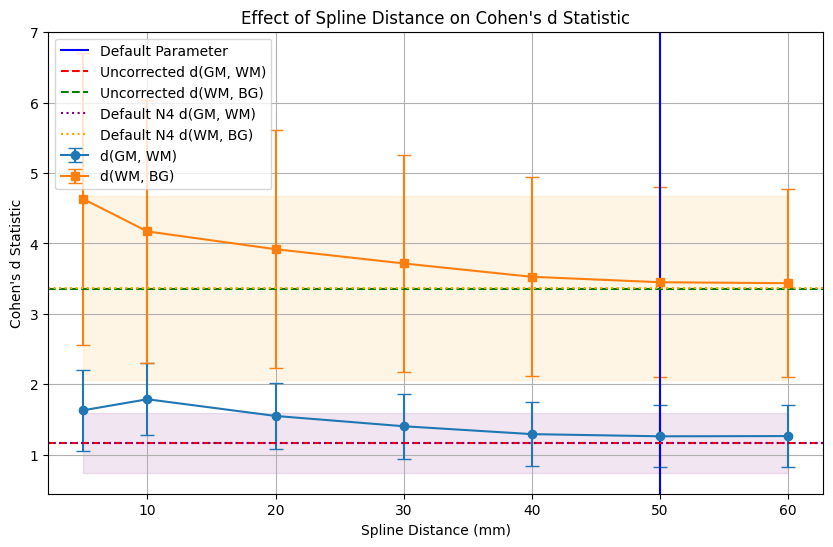

In [ ]:
from matplotlib import pyplot as plt

# Test different spline distances
spline_distances = [5, 10, 20, 30, 40, 50, 60]

# Initialize lists to store results
d_gm_wm_experiment_spline = []
d_wm_bg_experiment_spline = []
d_gm_wm_std_experiment_spline = []
d_wm_bg_std_experiment_spline = []
parameter_values_spline = []

# Keep other parameters constant
max_iterations = [50]  # Default value
convergence_threshold = 1e-6
full_width_at_half_maximum = 0.15

for spline_distance in spline_distances:
    d_gm_wm_list = []
    d_wm_bg_list = []

    for subject in subjects:
        # Load the T2-weighted image and CISS image
        t2_image = sitk.ReadImage(data_path + f'subj_{subject}_t2.nii.gz')
        ciss_image = sitk.ReadImage(data_path + f'subj_{subject}_ciss.nii.gz')

        # Generate brain mask
        brain_mask = compute_brain_mask(ciss_image)  # Default is OTSU

        # Downsample image and brain mask
        shrink_factor = 2
        downsampled_img = downsample_image_t2(t2_image, shrink_factor=shrink_factor)
        downsampled_brain_mask = downsample_brain_mask(brain_mask, shrink_factor=shrink_factor)

        # Initialize N4 filter
        N4 = sitk.N4BiasFieldCorrectionImageFilter()
        N4.SetMaximumNumberOfIterations(max_iterations)
        N4.SetConvergenceThreshold(convergence_threshold)
        N4.SetBiasFieldFullWidthAtHalfMaximum(full_width_at_half_maximum)

        # Set the spline distance by calculating the number of control points
        def get_physical_size(image):
            size = np.array(image.GetSize())
            spacing = np.array(image.GetSpacing())
            return size * spacing

        def calculate_control_points(image, spline_distance, spline_order=3):
            physical_size = get_physical_size(image)
            control_points = ((physical_size / spline_distance) + spline_order).astype(int)
            return control_points.tolist()

        control_points = calculate_control_points(downsampled_img, spline_distance)
        N4.SetNumberOfControlPoints(control_points)

        # Apply N4 bias field correction
        corrected_downsampled_img = N4.Execute(downsampled_img, downsampled_brain_mask)

        # Get the log bias field and apply it to the full-resolution image
        log_bias_field = N4.GetLogBiasFieldAsImage(t2_image)

        # Cast the original input image to Float32 to avoid division errors
        t2_image_float = sitk.Cast(t2_image, sitk.sitkFloat32)
        corrected_image_full_res = sitk.Divide(t2_image_float, sitk.Exp(log_bias_field))
        corrected_array = sitk.GetArrayFromImage(corrected_image_full_res)

        # Load the labels
        labels_image = sitk.ReadImage(segmentation_path + f'subj{subject}_t2_n4sam.nii.gz')
        labels_array = sitk.GetArrayFromImage(labels_image)

        # Compute statistics for each tissue class
        mean_gm, std_gm = compute_statistics(corrected_array, labels_array, label_gray_matter)
        mean_wm, std_wm = compute_statistics(corrected_array, labels_array, label_white_matter)
        mean_bg, std_bg = compute_statistics(corrected_array, labels_array, label_background)

        # Compute Cohen's d statistics
        d_gm_wm = compute_cohens_d(mean_gm, std_gm, mean_wm, std_wm)
        d_wm_bg = compute_cohens_d(mean_wm, std_wm, mean_bg, std_bg)

        # Store the results
        d_gm_wm_list.append(d_gm_wm)
        d_wm_bg_list.append(d_wm_bg)

    # Compute mean and std d-statistics for this parameter setting
    mean_d_gm_wm = np.mean(d_gm_wm_list)
    std_d_gm_wm = np.std(d_gm_wm_list)
    mean_d_wm_bg = np.mean(d_wm_bg_list)
    std_d_wm_bg = np.std(d_wm_bg_list)

    # Store the mean and std values
    d_gm_wm_experiment_spline.append(mean_d_gm_wm)
    d_wm_bg_experiment_spline.append(mean_d_wm_bg)
    d_gm_wm_std_experiment_spline.append(std_d_gm_wm)
    d_wm_bg_std_experiment_spline.append(std_d_wm_bg)
    parameter_values_spline.append(spline_distance)

# Find the best spline distance
best_index_spline = np.argmax(d_gm_wm_experiment_spline)
best_spline_distance = parameter_values_spline[best_index_spline]
print(f"Best spline distance: {best_spline_distance} mm")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.errorbar(parameter_values_spline, d_gm_wm_experiment_spline, yerr=d_gm_wm_std_experiment_spline, fmt='-o', capsize=5, label='d(GM, WM)')
plt.errorbar(parameter_values_spline, d_wm_bg_experiment_spline, yerr=d_wm_bg_std_experiment_spline, fmt='-s', capsize=5, label='d(WM, BG)')


# Plot the default parameter value
# The default control point grid size in SITK is 4 in each dimension, which, in our images corresponds to around 50mm (images are not the same size in all dimensions, and some have different sized from the others)
default_spline_distance = 50  # SITK reverse-calculated, approximate for our images.
plt.axvline(x=default_spline_distance, color='blue', linestyle='-', label='Default Parameter')

# Plot the uncorrected value
plt.axhline(y=mean_d_gm_wm_uncorrected, color='red', linestyle='--', label='Uncorrected d(GM, WM)')
plt.axhline(y=mean_d_wm_bg_uncorrected, color='green', linestyle='--', label='Uncorrected d(WM, BG)')

# Plot the default N4 d-statistics as dotted horizontal lines
plt.axhline(y=mean_d_gm_wm_corrected_default, color='purple', linestyle=':', label='Default N4 d(GM, WM)')
plt.axhline(y=mean_d_wm_bg_corrected_default, color='orange', linestyle=':', label='Default N4 d(WM, BG)')

# Add shaded regions for the default N4 std deviations
plt.fill_between(parameter_values_spline,
                 [mean_d_gm_wm_corrected_default - std_d_gm_wm_corrected_default]*len(parameter_values_spline),
                 [mean_d_gm_wm_corrected_default + std_d_gm_wm_corrected_default]*len(parameter_values_spline),
                 color='purple', alpha=0.1)

plt.fill_between(parameter_values_spline,
                 [mean_d_wm_bg_corrected_default - std_d_wm_bg_corrected_default]*len(parameter_values_spline),
                 [mean_d_wm_bg_corrected_default + std_d_wm_bg_corrected_default]*len(parameter_values_spline),
                 color='orange', alpha=0.1)


plt.xlabel('Spline Distance (mm)')
plt.ylabel('Cohen\'s d Statistic')
plt.title('Effect of Spline Distance on Cohen\'s d Statistic')
plt.legend()
plt.grid(True)
plt.show()


Reducing the spline distance in the N4 algorithm can enhance its performance because a finer B-spline mesh more effectively captures variations in the bias field. Smaller spline distances mean more control points are used, allowing for a more detailed approximation of the bias field and helping to reduce dropout artifacts.

However, setting the spline distance too low isn't always better. If it's too small, it can lead to overfitting or increased computational time. It's important to find a balance that suits the specific characteristics of the MRI data. For instance, when we set the spline distance to 5, the d-statistic between gray and white matter actually decreased, illustrating that overly small spline distances may negatively impact performance.

Then, let's experiment with different values of Maximum Number of Iterations:

Best maximum number of iterations: [50, 40, 30, 20]


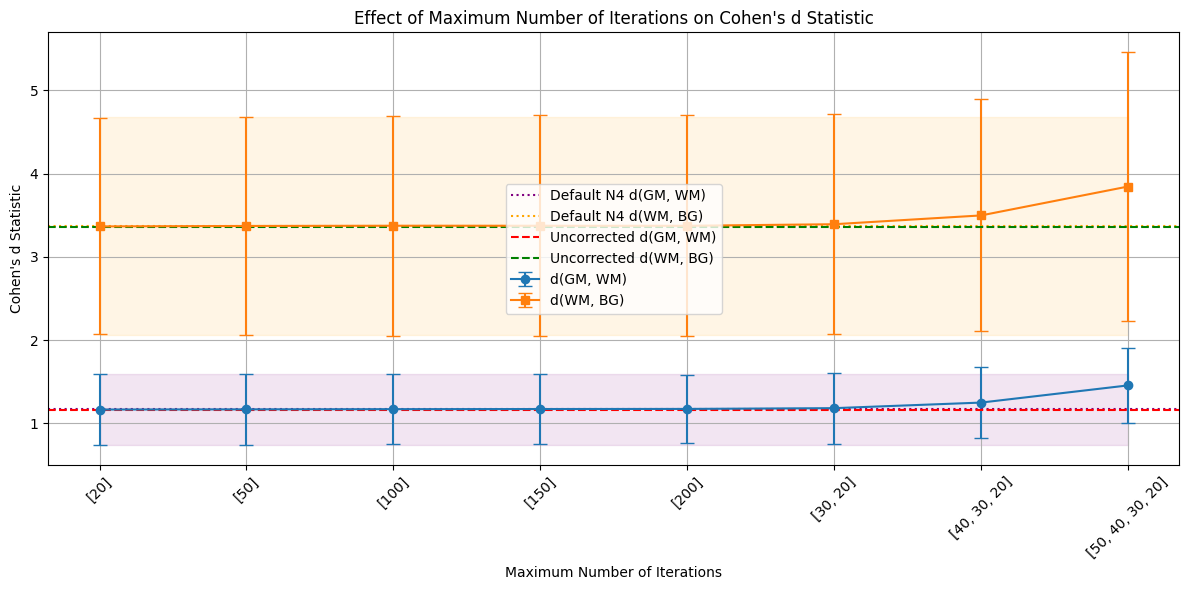

In [ ]:
# Test number of iterations, both in terms of number of iterations, as well as number of layers.
max_iterations = [[20], [50], [100], [150], [200],
                  [30, 20],
                  [40, 30, 20],
                  [50, 40, 30, 20]]

# Initialize lists to store results
d_gm_wm_experiment_iterations = []
d_wm_bg_experiment_iterations = []
d_gm_wm_std_experiment_iterations = []
d_wm_bg_std_experiment_iterations = []
parameter_values_iterations = []


# Keep other parameters constant
convergence_threshold = 1e-6
full_width_at_half_maximum = 0.15

for max_iter in max_iterations:
    d_gm_wm_list = []
    d_wm_bg_list = []

    for subject in subjects:
        # Load the T2-weighted image and CISS image
        t2_image = sitk.ReadImage(data_path + f'subj_{subject}_t2.nii.gz')
        ciss_image = sitk.ReadImage(data_path + f'subj_{subject}_ciss.nii.gz')

        # Generate brain mask
        brain_mask = compute_brain_mask(ciss_image)  # Default is OTSU

        # Downsample image and brain mask
        shrink_factor = 2
        downsampled_img = downsample_image_t2(t2_image, shrink_factor=shrink_factor)
        downsampled_brain_mask = downsample_brain_mask(brain_mask, shrink_factor=shrink_factor)

        # Initialize N4 filter
        N4 = sitk.N4BiasFieldCorrectionImageFilter()
        N4.SetMaximumNumberOfIterations(max_iter)
        N4.SetConvergenceThreshold(convergence_threshold)
        N4.SetBiasFieldFullWidthAtHalfMaximum(full_width_at_half_maximum)
        # We will not use the optimal spline distance, but let the default value.

        # Apply N4 bias field correction
        corrected_downsampled_img = N4.Execute(downsampled_img, downsampled_brain_mask)

        # Get the log bias field and apply it to the full-resolution image
        log_bias_field = N4.GetLogBiasFieldAsImage(t2_image)

        # Cast the original input image to Float32 to avoid division errors
        t2_image_float = sitk.Cast(t2_image, sitk.sitkFloat32)
        corrected_image_full_res = sitk.Divide(t2_image_float, sitk.Exp(log_bias_field))
        corrected_array = sitk.GetArrayFromImage(corrected_image_full_res)

        # Load the labels
        labels_image = sitk.ReadImage(segmentation_path + f'subj{subject}_t2_n4sam.nii.gz')
        labels_array = sitk.GetArrayFromImage(labels_image)

        # Compute statistics for each tissue class
        mean_gm, std_gm = compute_statistics(corrected_array, labels_array, label_gray_matter)
        mean_wm, std_wm = compute_statistics(corrected_array, labels_array, label_white_matter)
        mean_bg, std_bg = compute_statistics(corrected_array, labels_array, label_background)

        # Compute Cohen's d statistics
        d_gm_wm = compute_cohens_d(mean_gm, std_gm, mean_wm, std_wm)
        d_wm_bg = compute_cohens_d(mean_wm, std_wm, mean_bg, std_bg)

        # Store the results
        d_gm_wm_list.append(d_gm_wm)
        d_wm_bg_list.append(d_wm_bg)

    # Compute mean and std d-statistics for this parameter setting
    mean_d_gm_wm = np.mean(d_gm_wm_list)
    std_d_gm_wm = np.std(d_gm_wm_list)
    mean_d_wm_bg = np.mean(d_wm_bg_list)
    std_d_wm_bg = np.std(d_wm_bg_list)

    # Store the mean and std values
    d_gm_wm_experiment_iterations.append(mean_d_gm_wm)
    d_wm_bg_experiment_iterations.append(mean_d_wm_bg)
    d_gm_wm_std_experiment_iterations.append(std_d_gm_wm)
    d_wm_bg_std_experiment_iterations.append(std_d_wm_bg)
    parameter_values_iterations.append(str(max_iter))


# Find the best max_iterations
best_index_iter = np.argmax(d_gm_wm_experiment_iterations)
best_max_iterations = max_iterations[best_index_iter]
print(f"Best maximum number of iterations: {best_max_iterations}")

# Plotting the results
plt.figure(figsize=(12, 6))
x_positions = np.arange(len(parameter_values_iterations))

# Plot with error bars
plt.errorbar(x_positions, d_gm_wm_experiment_iterations, yerr=d_gm_wm_std_experiment_iterations, fmt='-o', capsize=5, label='d(GM, WM)')
plt.errorbar(x_positions, d_wm_bg_experiment_iterations, yerr=d_wm_bg_std_experiment_iterations, fmt='-s', capsize=5, label='d(WM, BG)')

# Plot the default N4 d-statistics as dotted horizontal lines
plt.axhline(y=mean_d_gm_wm_corrected_default, color='purple', linestyle=':', label='Default N4 d(GM, WM)')
plt.axhline(y=mean_d_wm_bg_corrected_default, color='orange', linestyle=':', label='Default N4 d(WM, BG)')

# Optionally, add shaded regions for the default N4 std deviations
plt.fill_between(x_positions,
                 [mean_d_gm_wm_corrected_default - std_d_gm_wm_corrected_default]*len(x_positions),
                 [mean_d_gm_wm_corrected_default + std_d_gm_wm_corrected_default]*len(x_positions),
                 color='purple', alpha=0.1)

plt.fill_between(x_positions,
                 [mean_d_wm_bg_corrected_default - std_d_wm_bg_corrected_default]*len(x_positions),
                 [mean_d_wm_bg_corrected_default + std_d_wm_bg_corrected_default]*len(x_positions),
                 color='orange', alpha=0.1)

# Plot the uncorrected value as dashed horizontal lines
plt.axhline(y=mean_d_gm_wm_uncorrected, color='red', linestyle='--', label='Uncorrected d(GM, WM)')
plt.axhline(y=mean_d_wm_bg_uncorrected, color='green', linestyle='--', label='Uncorrected d(WM, BG)')

# Set x-ticks and labels
plt.xticks(x_positions, parameter_values_iterations, rotation=45)
plt.xlabel('Maximum Number of Iterations')
plt.ylabel('Cohen\'s d Statistic')
plt.title('Effect of Maximum Number of Iterations on Cohen\'s d Statistic')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

We experimented with increasing the maximum number of iterations at a single resolution level and also tested the use of multiple resolution levels. When using a single resolution level, we observed that the d-statistic between grey matter and white matter and between white matter and the background increased proportionally with the number of maximum iterations. At a single resolution level, the N4 algorithm continues to refine the bias field correction as the number of iterations increases. As the algorithm processes more iterations, it becomes more effective at enhancing the contrast between tissues.


Similarly, when we increase the number of resolution levels up to 4 the d statistics between the tissues improve relatively to the the single-level resolution. In a multiresolution approach, each successive level aims to correct increasingly smaller and more localized intensity variations, leading to an overall improvement in the separation between tissue types

Let's run the default N4 algorithm to correct the images:

In [ ]:
# Default parameters:
max_iterations = [50]
convergence_threshold = 1e-6
full_width_at_half_maximum = 0.15

d_gm_wm_list = []
d_wm_bg_list = []

for subject in all_subjects:
    # Load the T2-weighted image and CISS image
    t2_image = sitk.ReadImage(data_path + f'subj_{subject}_t2.nii.gz')
    ciss_image = sitk.ReadImage(data_path + f'subj_{subject}_ciss.nii.gz')

    # Generate brain mask
    brain_mask = compute_brain_mask(ciss_image)  # Default is OTSU

    # Downsample image and brain mask
    shrink_factor = 2
    downsampled_img = downsample_image_t2(t2_image, shrink_factor=shrink_factor)
    downsampled_brain_mask = downsample_brain_mask(brain_mask, shrink_factor=shrink_factor)

    # Initialize N4 filter
    N4 = sitk.N4BiasFieldCorrectionImageFilter()
    N4.SetMaximumNumberOfIterations(max_iterations)
    N4.SetConvergenceThreshold(convergence_threshold)
    N4.SetBiasFieldFullWidthAtHalfMaximum(full_width_at_half_maximum)

    # Apply N4 bias field correction
    corrected_downsampled_img = N4.Execute(downsampled_img, downsampled_brain_mask)

    # Get the log bias field and apply it to the full-resolution image
    log_bias_field = N4.GetLogBiasFieldAsImage(t2_image)

    # Cast the original input image to Float32 to avoid division errors
    t2_image_float = sitk.Cast(t2_image, sitk.sitkFloat32)
    corrected_image_full_res = sitk.Divide(t2_image_float, sitk.Exp(log_bias_field))
    corrected_array = sitk.GetArrayFromImage(corrected_image_full_res)

    # Save corrected image
    sitk.WriteImage(corrected_image_full_res, f'{output_path}/corrected_data_default/subj{subject}_t2_n4.nii.gz')

Now we choose the best parameters and run the N4 algorithm for all the 20 subjects. Results can be found [here](https://drive.google.com/drive/folders/1Cj7P7VdUZP0aLhBUAxkMx2UTBvSSCa-H?usp=sharing) (access only through UPenn SEAS account).

In [ ]:
# Get parameters with best results (larger d statistic)
spline_distance = best_spline_distance # 10
max_iterations = best_max_iterations # [50, 40, 30, 20]
convergence_threshold = 1e-6
full_width_at_half_maximum = 0.15

d_gm_wm_list = []
d_wm_bg_list = []

for subject in all_subjects:
    # Load the T2-weighted image and CISS image
    t2_image = sitk.ReadImage(data_path + f'subj_{subject}_t2.nii.gz')
    ciss_image = sitk.ReadImage(data_path + f'subj_{subject}_ciss.nii.gz')

    # Generate brain mask
    brain_mask = compute_brain_mask(ciss_image)  # Default is OTSU

    # Downsample image and brain mask
    shrink_factor = 2
    downsampled_img = downsample_image_t2(t2_image, shrink_factor=shrink_factor)
    downsampled_brain_mask = downsample_brain_mask(brain_mask, shrink_factor=shrink_factor)

    # Initialize N4 filter
    N4 = sitk.N4BiasFieldCorrectionImageFilter()
    N4.SetMaximumNumberOfIterations(max_iterations)
    N4.SetConvergenceThreshold(convergence_threshold)
    N4.SetBiasFieldFullWidthAtHalfMaximum(full_width_at_half_maximum)
    # Set the optimal spline distance
    control_points = calculate_control_points(downsampled_img, spline_distance)
    N4.SetNumberOfControlPoints(control_points)

    # Apply N4 bias field correction
    corrected_downsampled_img = N4.Execute(downsampled_img, downsampled_brain_mask)

    # Get the log bias field and apply it to the full-resolution image
    log_bias_field = N4.GetLogBiasFieldAsImage(t2_image)

    # Cast the original input image to Float32 to avoid division errors
    t2_image_float = sitk.Cast(t2_image, sitk.sitkFloat32)
    corrected_image_full_res = sitk.Divide(t2_image_float, sitk.Exp(log_bias_field))
    corrected_array = sitk.GetArrayFromImage(corrected_image_full_res)

    # Save corrected image
    sitk.WriteImage(corrected_image_full_res, f'{output_path}/corrected_data/subj{subject}_t2_n4.nii.gz')

Now, let's compute the Cohen's d-statistic with the N4-corrected images (6 hemispheres), with optimal parameters:

In [ ]:
d_gm_wm_corrected_optimal = []
d_wm_bg_corrected_optimal = []

for subject in subjects:
    # Load the image
    t2_image = sitk.ReadImage(output_path + f'corrected_data/subj{subject}_t2_n4.nii.gz')
    t2_array = sitk.GetArrayFromImage(t2_image)

    # Load the labels
    labels_image = sitk.ReadImage(segmentation_path + f'/subj{subject}_t2_n4sam.nii.gz')
    labels_array = sitk.GetArrayFromImage(labels_image)

    # Compute statistics for each tissue class
    mean_gm, std_gm = compute_statistics(t2_array, labels_array, label_gray_matter)
    mean_wm, std_wm = compute_statistics(t2_array, labels_array, label_white_matter)
    mean_bg, std_bg = compute_statistics(t2_array, labels_array, label_background)

    # Compute Cohen's d statistics
    d_gm_wm = compute_cohens_d(mean_gm, std_gm, mean_wm, std_wm)
    d_wm_bg = compute_cohens_d(mean_wm, std_wm, mean_bg, std_bg)

    # Store the results
    d_gm_wm_corrected_optimal.append(d_gm_wm)
    d_wm_bg_corrected_optimal.append(d_wm_bg)


# Compute mean and standard deviation of the d-statistics
mean_d_gm_wm_corrected_optimal = round(np.mean(d_gm_wm_corrected_optimal), 4)
std_d_gm_wm_corrected_optimal = round(np.std(d_gm_wm_corrected_optimal), 4)
mean_d_wm_bg_corrected_optimal = round(np.mean(d_wm_bg_corrected_optimal), 4)
std_d_wm_bg_corrected_optimal = round(np.std(d_wm_bg_corrected_optimal), 4)

print()
print("##########################################")
print("Corrected Images with Optimal Parameters:")
print()
print("Cohen's d-statistic for each subject:")
for i in range(len(subjects)):
    print("Subject " + subjects[i] + ":\n ├── d(GM, WM): ", d_gm_wm_corrected_optimal[i], "\n └── d(WM, BG): ",  d_wm_bg_corrected_optimal[i])
print()
print(f"Mean d(GM, WM): {mean_d_gm_wm_corrected_optimal:.4f}, Std: {std_d_gm_wm_corrected_optimal:.4f}")
print(f"Mean d(WM, BG): {mean_d_wm_bg_corrected_optimal:.4f}, Std: {std_d_wm_bg_corrected_optimal:.4f}")
print("##########################################")
print()


##########################################
Corrected Images with Optimal Parameters:

Cohen's d-statistic for each subject:
Subject 002:
 ├── d(GM, WM):  2.2168 
 └── d(WM, BG):  3.0174
Subject 006:
 ├── d(GM, WM):  2.1381 
 └── d(WM, BG):  2.1199
Subject 009:
 ├── d(GM, WM):  0.8241 
 └── d(WM, BG):  2.1018
Subject 016:
 ├── d(GM, WM):  2.6172 
 └── d(WM, BG):  6.1559
Subject 017:
 ├── d(GM, WM):  2.3384 
 └── d(WM, BG):  5.532
Subject 019:
 ├── d(GM, WM):  0.6655 
 └── d(WM, BG):  7.2045

Mean d(GM, WM): 1.8000, Std: 0.7621
Mean d(WM, BG): 4.3552, Std: 2.0253
##########################################



Change their datatype so that they have a reduced file size:

In [ ]:
# Define the folders containing the images
folders = ['corrected_data', 'corrected_data_default']

# Loop over each folder
for folder in folders:
    folder_path = os.path.join(output_path, folder)

    # Get a list of NIfTI files in the folder
    files = [f for f in os.listdir(folder_path) if f.endswith('.nii.gz') or f.endswith('.nii')]

    for filename in files:
        file_path = os.path.join(folder_path, filename)
        print(f"Processing {file_path}")

        # Read the image
        image = sitk.ReadImage(file_path)

        # Get the pixel type
        pixel_type = image.GetPixelIDTypeAsString()
        print(f'Original Pixel Type: {pixel_type}')

        # Get the intensity range
        stats = sitk.StatisticsImageFilter()
        stats.Execute(image)
        min_intensity = stats.GetMinimum()
        max_intensity = stats.GetMaximum()
        print(f'Intensity Range: {min_intensity} to {max_intensity}')

        # Rescale intensity to 0-65535
        intensity_range = max_intensity - min_intensity
        if intensity_range == 0:
            print(f'Warning: Zero intensity range in {filename}. Skipping.')
            continue

        # Rescale the image
        rescale_filter = sitk.RescaleIntensityImageFilter()
        rescale_filter.SetOutputMinimum(0)
        rescale_filter.SetOutputMaximum(65535)
        rescaled_image = rescale_filter.Execute(image)

        # Cast to UInt16
        cast_image = sitk.Cast(rescaled_image, sitk.sitkUInt16)
        new_pixel_type = cast_image.GetPixelIDTypeAsString()
        print(f'New Pixel Type: {new_pixel_type}')

        # Save the image (overwrite original)
        sitk.WriteImage(cast_image, file_path)

        print('---')

Processing 2.5/corrected_data/subj018_t2_n4.nii.gz
Original Pixel Type: 16-bit unsigned integer
Intensity Range: 0.0 to 14742.0
New Pixel Type: 16-bit unsigned integer
---
Processing 2.5/corrected_data/subj019_t2_n4.nii.gz
Original Pixel Type: 16-bit unsigned integer
Intensity Range: 0.0 to 14310.0
New Pixel Type: 16-bit unsigned integer
---
Processing 2.5/corrected_data/subj006_t2_n4.nii.gz
Original Pixel Type: 16-bit unsigned integer
Intensity Range: 0.0 to 5252.0
New Pixel Type: 16-bit unsigned integer
---
Processing 2.5/corrected_data/subj001_t2_n4.nii.gz
Original Pixel Type: 16-bit unsigned integer
Intensity Range: 0.0 to 3378.0
New Pixel Type: 16-bit unsigned integer
---
Processing 2.5/corrected_data/subj014_t2_n4.nii.gz
Original Pixel Type: 16-bit unsigned integer
Intensity Range: 0.0 to 14923.0
New Pixel Type: 16-bit unsigned integer
---
Processing 2.5/corrected_data/subj013_t2_n4.nii.gz
Original Pixel Type: 16-bit unsigned integer
Intensity Range: 0.0 to 16556.0
New Pixel Type

Below we present the uncorrected and corrected images of 3 example hemispheres, using both the default and best parameters:

Subject 5 initial T2 scan:

![](https://drive.google.com/uc?export=view&id=1WwZDR8YN0B3HIaKL_c6cqaeVqw-KH7n9)

----

Subject 5 default parameters:

![](https://drive.google.com/uc?export=view&id=16pi9_iSodgqtWybUHCE66yDk57N5LVQD)

----

Subject 5 optimal parameters:

![](https://drive.google.com/uc?export=view&id=1eGwRkEKozK60ssWllpmHCsP2_9by-gEr)

----

Subject 10 initial T2 scan:

![](https://drive.google.com/uc?export=view&id=1HytNO5PshcJxHf9MzQPBHRujiwg4W_CV)

----

Subject 10 default parameters:


![](https://drive.google.com/uc?export=view&id=1kRbulteuuEqHatHRFdGmW49-DlOclyVG)

----

Subject 10 optimal parameters:

![](https://drive.google.com/uc?export=view&id=1UNi5mpZ-I0OwFg31BBgA9JUlMW2BDXlV)

----

Subject 20 initial T2 scan:


![](https://drive.google.com/uc?export=view&id=1osrbv2ZPIZWnZAwpZ5AQy3Zplmco9P7L)

----

Subject 20 default parameters:


![](https://drive.google.com/uc?export=view&id=1lxHyDpbaPQAg3d4au6Avw54XMajbJVqz)

----

Subject 20 optimal parameters:


![](https://drive.google.com/uc?export=view&id=1L-pWheaMBthwpQntb6-g-KRvVNlHgkB2)









We observe that there is a *very* minor improvement when applying the N4 algorithm with the default parameters, and a much more significant improvement when N4 is applied with the optimal parameters.

Overall, the N4 algorithm proved to be effective in correcting bias fields in brain T2 MRI images, though its performance depends heavily on tuning key parameters, as with default parameters the improvement was small. Spline distance, number of resolution levels, and maximum number of iterations were critical parameters for optimizing its performance. The smaller the spline distance (5 mm), the better the results, as N4 algorithm captures finer variations in the bias field and reduces dropout artifact (with a little caution to overfitting). Increasing the number of multiresolution levels improved dropout artifact by enabling a hierarchical fitting of the bias field. The maximum number of iterations also played an important role, with improvements observed up to around 200 iterations. Balancing these parameters allowed us to achieve the best results in terms of bias field correction while preserving tissue contrast.

### 3 Phase II: Generating a Training Dataset

#### 3.1 Step II-A. Examine hemisphere anatomy

First, let's apply N4 to our assigned hemispheres (subject 20 and subject 23) with the optimal parameters from Phase I. These are:

- Shrink Factor = 4,
- Spline Order = 2,
- Iterations = [60,60,60,60]
- spline_distance=10,
- numIterations=125,
- convergenceThresholds=0.0001

We are also going to downsample the image and create (and apply) a brain mask:

In [ ]:
shrink_factor = 4
spline_order = 2
iterations = [60,60,60,60]
spline_distance = 10
max_iter = 360
convergence_threshold = 0.0001


The function used to apply N4 algorithm to a scan a reduce dropout artifact is presented below. Firstly we create the mask of the scan using OTSU threshold. Then we set the parameters of the algorithm and we downsample the original image and the mask. The bias field is calculated by the N4 algorithm and the corrected image results from dividing the original image by the bias field

In [ ]:
def apply_N4_optimal(image_t2, image_ciss, shrink_factor=4, spline_order=2, iterations=[60,60,60,60], spline_distance=10, max_iter=360, convergence_threshold=0.0001, full_width_at_half_maximum=0.15):
    brain_mask_OTSU = sitk.OtsuThreshold(image_ciss, 0, 1, 200) # Inside value is 1, outside is 0. Num of bins=200
    sigma = 0.65

    shrink_factors = [shrink_factor] * image_t2.GetDimension()

    img_after_low_pass = sitk.SmoothingRecursiveGaussian(image_t2, sigma)
    image_downsampled = sitk.Shrink(img_after_low_pass, shrink_factors)

    # Set the spline distance by calculating the number of control points
    def get_physical_size(image):
        size = np.array(image.GetSize())
        spacing = np.array(image.GetSpacing())
        return size * spacing

    def calculate_control_points(image, spline_distance, spline_order=3):
        physical_size = get_physical_size(image)
        control_points = ((physical_size / spline_distance) + spline_order).astype(int)
        return control_points.tolist()

    downsampled_brain_mask = sitk.BinShrink(brain_mask_OTSU, shrink_factors)
    # Initialize N4 filter and set parameters:
    N4 = sitk.N4BiasFieldCorrectionImageFilter()
    N4.SetMaximumNumberOfIterations(iterations)
    N4.SetConvergenceThreshold(convergence_threshold)
    N4.SetBiasFieldFullWidthAtHalfMaximum(full_width_at_half_maximum)

    control_points = calculate_control_points(image_downsampled, spline_distance)
    N4.SetNumberOfControlPoints(control_points)

    corrected_downsampled_img = N4.Execute(image_downsampled, downsampled_brain_mask)

    # Get the log bias field and apply it to the full-resolution image
    log_bias_field = N4.GetLogBiasFieldAsImage(image_t2)

    # Cast the original input image to Float32 to avoid division errors
    image_t2_float = sitk.Cast(image_t2, sitk.sitkFloat32)
    corrected_image_full_res = sitk.Divide(image_t2_float, sitk.Exp(log_bias_field))

    return corrected_image_full_res

Apply N4 algorithm to assigned hemispheres of subjects '020' and '023' in order to improve dropout artifact.

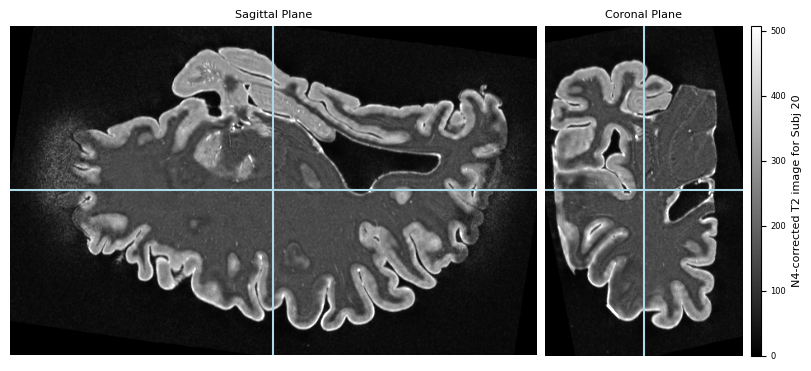

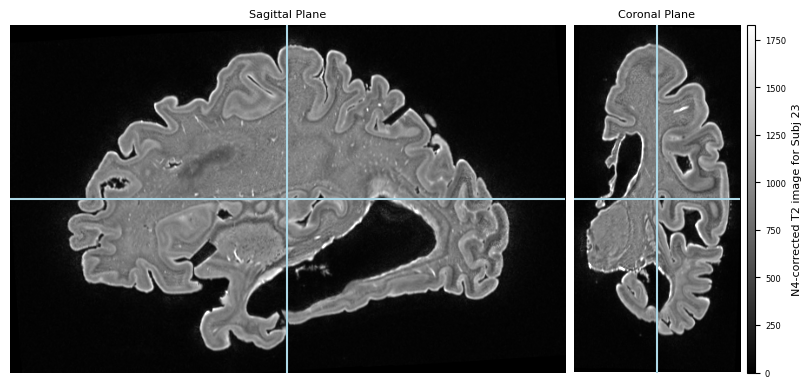

In [ ]:
subj_20_t2 = sitk.ReadImage(data_path + 'subj_020_t2.nii.gz')
subj_20_ciss = sitk.ReadImage(data_path + 'subj_020_ciss.nii.gz')
subj_23_t2 = sitk.ReadImage(data_path + 'subj_023_t2.nii.gz')
subj_23_ciss = sitk.ReadImage(data_path + 'subj_023_ciss.nii.gz')


subj_20_n4_corrected = apply_N4_optimal(subj_20_t2, subj_20_ciss)
subj_23_n4_corrected = apply_N4_optimal(subj_23_t2, subj_23_ciss)

view_hemi(subj_20_n4_corrected, cmap='gray', name='N4-corrected T2 image for Subj 20')
view_hemi(subj_23_n4_corrected, cmap='gray', name='N4-corrected T2 image for Subj 23')

# Save n4_corrected images for annotation:
if local:
  output_path = '3.1/'
else:
  output_path = '/content/drive/MyDrive/BIA_Segmentation/3.1/'
cast_image = sitk.Cast(subj_20_n4_corrected, sitk.sitkUInt16)
sitk.WriteImage(cast_image, output_path + "subj_20_n4_corrected.nii.gz")
cast_image = sitk.Cast(subj_23_n4_corrected, sitk.sitkUInt16)
sitk.WriteImage(cast_image, output_path + "subj_23_n4_corrected.nii.gz")


Below you can see the screenshots for our annotated subject hemispheres:

**Subject 23:**

![](https://drive.google.com/uc?export=view&id=1gAgn6Sx0mhmzrY5HiRqCMkv8kEcQsmkH)

As can be seen in the image above we identified the following structures on the corrected T2 scan of subject 23:

*   Cortical gray matter and white matter
*   Subcortical structures: caudate, putamen, thalamus
*   Limbic structures: hippocampus
*   Ventricles
*   Buried sulcus
*   Sampling regions

No significant White matter hyperintensities (WMH) were found in the scan.


\\
**Subject 20:**






#### 3.2 Step II-B. Extract patches from whole-hemisphere scans and perform QC

The function for extracting patches from whole-hemisphere scans is presented below. First, we generate a brain mask using OTSU thresholding. Next, we sample random x, y, z coordinates that serve as the starting points for the 64x64x64 patches, which we generate using the RegionOfInterest function. The image is then converted into an array, and the values within the patch are summed to calculate the brain tissue volume. We divide this by the total patch size to ensure that over 50% of the patch contains brain tissue. Then we find overlap of generated patch with previous saved ones to avoid it being over 20%. If the patch meets these criteria, it is added to our set. The algorithm continues until 5 valid T2 and 5 valid CISS patches are found, at which point it terminates.

In [ ]:
def extract_patches(image_t2, image_ciss, patch_size=64):
    size = image_t2.GetSize()  # (width, height, depth)
    patches = []  # List to store accepted patches and their positions
    patch_volume = patch_size ** 3  # Volume of the patch in voxels

    brain_mask_OTSU = sitk.OtsuThreshold(image_ciss, 0, 1, 200) # Inside value is 1, outside is 0. Num of bins=200

    while len(patches)<5:
        # Randomly select starting indices within the valid range
        x = random.randint(0, size[0] - patch_size)
        y = random.randint(0, size[1] - patch_size)
        z = random.randint(0, size[2] - patch_size)
        index = [x, y, z]
        region_size = [patch_size, patch_size, patch_size]

        # Extract the mask patch using RegionOfInterest
        mask_patch = sitk.RegionOfInterest(brain_mask_OTSU, region_size, index)

        # Convert mask patch to numpy array for analysis
        mask_array = sitk.GetArrayFromImage(mask_patch)
        brain_voxels = np.sum(mask_array)
        fraction = brain_voxels / patch_volume

        # Check if at least 50% of the voxels are brain tissue
        if fraction >= 0.5:
            # Check overlap with existing patches
            overlap = False
            for p in patches:
                # Get previous patch index and size
                prev_index = p['index']

                # Calculate overlap along each dimension
                overlap_x = max(0, min(x + patch_size, prev_index[0] + patch_size) - max(x, prev_index[0]))
                overlap_y = max(0, min(y + patch_size, prev_index[1] + patch_size) - max(y, prev_index[1]))
                overlap_z = max(0, min(z + patch_size, prev_index[2] + patch_size) - max(z, prev_index[2]))

                # Calculate the overlap volume
                overlap_volume = overlap_x * overlap_y * overlap_z

                # Check if overlap exceeds 20% of patch volume
                if overlap_volume / patch_volume > 0.2:
                    overlap = True
                    continue  # No need to check further patches

            # If no significant overlap, accept the patch
            if not overlap:
                # Extract image patches from both T2 and CISS images
                t2_patch = sitk.RegionOfInterest(image_t2, region_size, index)
                ciss_patch = sitk.RegionOfInterest(image_ciss, region_size, index)

                # Store the patches and their starting indices
                patches.append({'t2_patch': t2_patch, 'ciss_patch': ciss_patch, 'index': index})
                continue  # Proceed to find the next patch

    return patches


We extract 10 valid patches from hemisphere belonging to subject 23 (5 patches from T2 scan and the corresponding 5 patches from CISS scans).

In [ ]:
# Extract patches
patches = extract_patches(subj_23_t2, subj_23_ciss)

output_path = '3.2/'

# Access the extracted patches
for i, patch_info in enumerate(patches):
    t2_patch = patch_info['t2_patch']
    ciss_patch = patch_info['ciss_patch']
    index = patch_info['index']
    print(f"Patch {i+1}: Start Index = {index}")
    sitk.WriteImage(t2_patch, output_path + "subj_023_team20_patch_0"+str(i)+"_t2_n4.nii.gz")
    sitk.WriteImage(ciss_patch, output_path + "subj_023_team20_patch_0"+str(i)+"_ciss.nii.gz")

In [ ]:
!fsleyes \
    3.2/subj_023_team20_patch_00_t2_n4.nii.gz        -cm red    \
    3.2/subj_023_team20_patch_00_ciss.nii.gz         -cm yellow \
    3.2/subj_023_team20_patch_01_t2_n4.nii.gz        -cm green  \
    3.2/subj_023_team20_patch_01_ciss.nii.gz         -cm cyan   \
    3.2/subj_023_team20_patch_02_t2_n4.nii.gz        -cm blue   \
    3.2/subj_023_team20_patch_02_ciss.nii.gz         -cm magenta\
    3.2/subj_023_team20_patch_03_t2_n4.nii.gz        -cm hot    \
    3.2/subj_023_team20_patch_03_ciss.nii.gz         -cm cool   \
    3.2/subj_023_team20_patch_04_t2_n4.nii.gz        -cm copper \
    3.2/subj_023_team20_patch_04_ciss.nii.gz         -cm spring

Now we need to evaluate that each of the generated patches (0 to 4) meet these four criteria:
*   Quality registration between T2 and CISS scans
*   Minimal intensity inhomogeneity
*   Does not contain subcortical structures (caudate, putamen, thalamus) or the hippocampus
*   Does not contain white matter hyperintensities

**Subject 23:**
It is clear that patch 0 contains large parts of caudate and putamen as can be seen in the image below. For this reason **patch 0 is rejected**.

![](https://drive.google.com/uc?export=view&id=1pSBlToyM1bl3ReR6fxHVagXVBZUH1Qcs)

Also patch 4 contains a big part of putamen and a small part of thalamus but in many slices as presented below. **Patch 4 is rejected** as well.

![](https://drive.google.com/uc?export=view&id=1oVOh9ar2dOlLmAkgxO1gjI07qdAX4aaT)

All the other patches (purple, blue and light red on the up right corner of the sagittal plane) are not close to subcortical structures.

![](https://drive.google.com/uc?export=view&id=19K4PSaziiylaffL9zviVdAg93LwyMSo-)

The three remaining patches do not have intensity inhomogeneity, as they are far away from the sides where this problem is mostly present. In addition, no signigicant white matter hyperintensities were observed while inspecting the images. Finally, as can be seen in the images below, the quality of the registration between T2 and CISS patches has high quality. This comparison can be done by overlaying the T2 scan with the CISS patches and decreasing their opacity gradually.

![](https://drive.google.com/uc?export=view&id=1V3hOE8VUY10ZvC9PG0jTYBfbaiqfJvxn)



#### 3.3 Step II-C. Segment the patches using ITK-SNAP

#### 3.4 Step II-D. Compare and combine team members’ segmentations

#### 3.5 Step II-E. Upload Final Segmentations to Shared Folder

### 4 Phase III - Train and evaluate nnU-Net

#### 4.1 Step III-A. Install nnU-Net

#### 4.2 Step III-B. Organize Data for nnU-Net

#### 4.3 Step III-C. Train nnU-Net and Report Segmentation Accuracy

#### 4.4 Step III-D. Apply nnU-Net to previously unseen whole-hemisphere images

#### 4.5 Step III-E. Write code to post-process nnU-Net segmentations

#### 4.6 Step III-F. Quantitative evaluation

#### 4.7 Step III-G. Comparative evaluation